### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [42]:
import pandas as pd

Наши новости

In [43]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [44]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [45]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [46]:
#предобработка текстов
import re
import numpy as np

from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2
import itertools
import warnings

warnings.simplefilter('ignore')

In [47]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

151

In [48]:
morph = pymorphy2.MorphAnalyzer()

In [49]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [50]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [51]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 31.4 s, sys: 192 ms, total: 31.6 s
Wall time: 31.7 s


In [52]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 16s, sys: 88.2 ms, total: 4min 16s
Wall time: 4min 16s


А теперь в 3 строчки обучим нашу модель

In [53]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [54]:
common_dictionary[1]

'александр'

Все просто - это словарь наших слов

Запускаем обучение

In [55]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 2s, sys: 440 ms, total: 1min 2s
Wall time: 39.5 s


In [56]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [57]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.48620427), (4, 0.3438439), (13, 0.07743617), (21, 0.07023399)]

In [58]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: температура препарат вицепремьер погода планета градус снять
topic_1: игра хороший команда продолжительность орден гость золото
topic_2: рак спрос кожа россиянин японский вырасти тур
topic_3: путин банк владимир россия пресссекретарить nn дмитрий
topic_4: военный сша американский действие nn наука российский
topic_5: украина фонд украинский смерть киев египет заявлять
topic_6: ребёнок исследование семья жизнь родитель русский расследование
topic_7: энергия сенатор лауреат грант армения писать су
topic_8: взрыв миссия вуз выдать ресторан спасти сестра
topic_9: статья белоруссия век мышь завод белорусский заявлять
topic_10: млрд nn мозг земля северный сша опубликовать
topic_11: участок конкурс ск торговый фотография мозг кость
topic_12: новый проект ракета эксперт цена большой рынок
topic_13: млн погибнуть nn место женщина болезнь первый
topic_14: гражданин научный наука поверхность академия журнал фронт
topic_15: россия российский nn сша газ экономика развитие
topic_16: рубль с

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [59]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [60]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.060664,0.0,0.498900,0.000000,0.0,0.0,0.0,0.0000,...,0.344932,0.000000,0.0,0.010715,0.000000,0.0,0.000000,0.000000,0.0,0.067372
1,4896,0.0,0.343977,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0393,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.459520
2,4897,0.0,0.486193,0.0,0.000000,0.343878,0.0,0.0,0.0,0.0000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.070242,0.000000,0.0,0.000000
3,4898,0.0,0.162883,0.0,0.000000,0.135662,0.0,0.0,0.0,0.0000,...,0.000000,0.021594,0.0,0.000000,0.240916,0.0,0.000000,0.099011,0.0,0.000000
4,4899,0.0,0.000000,0.0,0.147725,0.000000,0.0,0.0,0.0,0.0000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [62]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [114]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, vector="mean"):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if vector=="mean  ":
        user_vector = np.mean(user_vector, 0)
    elif vector=="median":
        user_vector = np.median(user_vector, 0)
    elif vector=="max   ":
        user_vector = np.max(user_vector, 0)
    return user_vector

In [115]:
target = pd.read_csv("users_churn.csv")

In [116]:
logreg = LogisticRegression()

In [137]:
for vector in ['mean  ', 'median', 'max   ']: 
    
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, vector=vector), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    
    X = pd.merge(user_embeddings, target, 'left')
    X.head(3)
    
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=42)
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    roc_auc_score(y_test, preds)

   
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
   
    print(f'|  {vector} F-Score={round(fscore[ix],6)}  Precision={round(precision[ix],6)}  Recall={round(recall[ix],6)}  Roc auc score={round(roc_auc_score(y_test, preds),6)}|')
    print(f'|--------------------------------------------------------------------------------------|')

|  mean   F-Score=0.686371  Precision=0.587079  Recall=0.826087  Roc auc score=0.949684|
|--------------------------------------------------------------------------------------|
|  median F-Score=0.762411  Precision=0.691318  Recall=0.849802  Roc auc score=0.969993|
|--------------------------------------------------------------------------------------|
|  max    F-Score=0.834244  Precision=0.773649  Recall=0.905138  Roc auc score=0.981287|
|--------------------------------------------------------------------------------------|


In [138]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1680   67]
 [  25  228]]


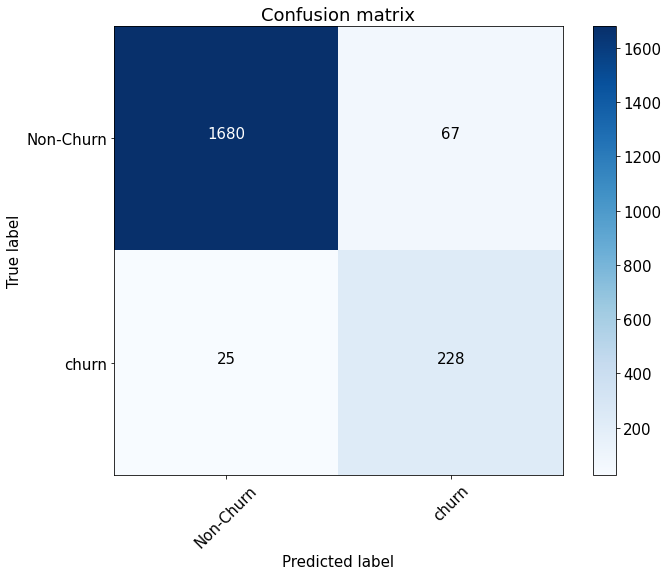

In [139]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [140]:
roc_auc_score(y_test, preds)

0.9812869492817727

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных